In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sklearn.preprocessing as preprocessing
import scipy.spatial.distance as distance
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data_dir = "..\data\\"
os.chdir(data_dir)

**1) [P] You will compute the distance matrix for data that is similar to a simple set shown in class, just a bit more
extensive. This will give you an opportunity to understand how to perform proximity measurements on data
with different types of variables on your own.**
**Set the types as follows:
<br>
• test1: Nominal, levels = { "A", "B", C" }
<br>
• test2: Ordinal, levels = { "poor", "fair", "good", "excellent" }
<br>
• test3: Numeric
<br>
Name the data frame df. Set the index correctly. Use the info() method to show the type of each
variable in df when you have completed your dataframe.**

In [3]:
df = pd.DataFrame(data={'test1':['A','C','C','B','A','B','C','B'], 
                       'test2':['excellent','fair','good','fair','poor',
                               'excellent','good','good'], 'test3':[25, 32,
                                                                   60,53,23,
                                                                   37,45,49]},
                 index=['A'+str(i) for i in range(8)])

In [4]:
df

,test1,test2,test3
A0,A,excellent,25
A1,C,fair,32
A2,C,good,60
A3,B,fair,53
A4,A,poor,23
A5,B,excellent,37
A6,C,good,45
A7,B,good,49


In [5]:
nom_dtype = pd.api.types.CategoricalDtype(categories=["A","B","C"])
df['test1'] = df['test1'].astype(nom_dtype)
cat_dtype = pd.api.types.CategoricalDtype(categories=["poor", "fair", "good", "excellent"], ordered = True)
df['test2'] = df['test2'].astype(cat_dtype)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, A0 to A7
Data columns (total 3 columns):
test1    8 non-null category
test2    8 non-null category
test3    8 non-null int64
dtypes: category(2), int64(1)
memory usage: 440.0+ bytes


**2) [P] Report the counts of each level of the categorical variables.**

In [7]:
df['test1'].value_counts()

C    3
B    3
A    2
Name: test1, dtype: int64

In [8]:
df['test2'].value_counts()

good         3
excellent    2
fair         2
poor         1
Name: test2, dtype: int64

**3) [P] Report a cross tabulation (i.e. contingency table) between test1 and test2. Include the margins (i.e. the
sum of the rows and the columns) in your reported table (HINT: Look up pandas crosstab() function)**

In [9]:
pd.crosstab(df['test1'], df['test2'], margins=True)

test2,poor,fair,good,excellent,All
test1,,,,,
A,1,0,0,1,2
B,0,1,1,1,3
C,0,1,2,0,3
All,2,2,3,1,8


**4) [P] From the previous table, store the contingency table without the margins in a variable called observed**

In [10]:
observed = pd.crosstab(df['test1'], df['test2'])

**5) [P] Run a chi-squared test for independence using the contingency table from the previous step. Clearly report
the chi2 statistic, the p value, and the degrees of freedom, and then use the p-value to clearly state whether
test1 and test2 are independent.**

In [11]:
stat, p, dof, expected = stats.chi2_contingency(observed, correction=False)
print("Chi2 statistic is {}".format(stat))
print("p value is {}".format(p))
print("Degrees of freedom are {}".format(dof))


Chi2 statistic is 6.444444444444444
p value is 0.37528525266160834
Degrees of freedom are 6


The p value is greater than a chosen significance level of 0.05 and so test1 and test2 are independent

**6) [P] Use describe() to report the summary statistics of variable test3.**

In [12]:
df['test3'].describe()

count     8.000000
mean     40.500000
std      13.416408
min      23.000000
25%      30.250000
50%      41.000000
75%      50.000000
max      60.000000
Name: test3, dtype: float64

**7) [P] Now, you're going to explore some similarities between observations. Yes, this is a SMALL dataset! (Don't
bother to explore large data until you can understand how they work on small, toy experimental data!)**

**Before you can compute a pairwise distance matrix to report the distance between all pairs of observations,
always remember that you can only compute distances between strictly numeric data. Therefore, you must
convert your data to numeric types for ALL variables you want to include in your distance metric.
Create a new data frame called df_num, that represents a numeric version of the above. Let's begin by
creating a version that stores all three variables above encoded as simple as possible. Do NOT rescale your
data... yet!**

In [13]:
df_num = df.copy()
df_num['test1'] = df_num['test1'].astype('category').cat.codes
df_num['test2'] = df_num['test2'].astype('category').cat.codes

In [14]:
df_num

,test1,test2,test3
A0,0,3,25
A1,2,1,32
A2,2,2,60
A3,1,1,53
A4,0,0,23
A5,1,3,37
A6,2,2,45
A7,1,2,49


**8) [P] As you learned in lecture, you absolutely must rescale your data to fall on a similar scale. There are
different approaches to doing so. A standardized zscore is among the most common, but not necessarily always the best approach, especially when you are dealing with numeric representations of true categorical
data. Rescaling your data to all fall between 0 and 1 is also a common approach, particularly when you have
categorical data. <br>
Let's first try to rescale our data to all fall between the values of 0 and 1. Use the MinMaxScaler in
sklearn.preprocessing to rescale all variables to fall between 0 and 1. Store the transformed data as a
pandas data frame called df_num_zeroone,.**

In [15]:
scaler = preprocessing.MinMaxScaler()
df_num_zeroone = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns, index=df_num.index)

In [16]:
df_num_zeroone

,test1,test2,test3
A0,0.0,1.000000,0.054054
A1,1.0,0.333333,0.243243
A2,1.0,0.666667,1.000000
A3,0.5,0.333333,0.810811
A4,0.0,0.000000,0.000000
A5,0.5,1.000000,0.378378
A6,1.0,0.666667,0.594595
A7,0.5,0.666667,0.702703


**9) Notice the value of test3. Quite often, when we have solid knowledge of what we expect our range to be,
then we can rescale our data using that knowledge. In the case of test3, you learned that the data must fall
between 0 and 100. Therefore, reassign test3 so that the min and max before rescaling are assuming to be
between 0 and 100, respectively. (i.e. simply divide the original variable by 100!)**

In [17]:
MAX = 100
MIN =0

df_num_zeroone['test3'] = df_num['test3']/(MAX - MIN)

In [18]:
df_num_zeroone

,test1,test2,test3
A0,0.0,1.000000,0.25
A1,1.0,0.333333,0.32
A2,1.0,0.666667,0.60
A3,0.5,0.333333,0.53
A4,0.0,0.000000,0.23
A5,0.5,1.000000,0.37
A6,1.0,0.666667,0.45
A7,0.5,0.666667,0.49


**10) [P] Compute a single distance matrix called distmat_zeroone. Use a standard Euclidean distance
measure. Your reported result should be an 8x8 matrix with appropriately labeled rows and columns. (HINT –
study the output of the distance matrix functions! They do not output a square matrix. Look at the
squareform function. The pdist and squareform functions are in scipy.spatial.distance).**

In [19]:
a = distance.squareform(distance.pdist(df_num_zeroone))
np.fill_diagonal(a, np.NaN)
distmat_zeroone = pd.DataFrame(a, columns= df_num.index, index=df_num.index)
distmat_zeroone

,A0,A1,A2,A3,A4,A5,A6,A7
A0,NaN,1.203887,1.110680,0.879116,1.000200,0.514198,1.072898,0.647079
A1,1.203887,NaN,0.435329,0.542310,1.057928,0.834832,0.357786,0.624509
A2,1.110680,0.435329,NaN,0.604989,1.257515,0.643437,0.150000,0.511957
A3,0.879116,0.542310,0.604989,NaN,0.671648,0.685598,0.606227,0.335725
A4,1.000200,1.057928,1.257515,0.671648,NaN,1.126765,1.221820,0.872952
A5,0.514198,0.834832,0.643437,0.685598,1.126765,NaN,0.606227,0.354275
A6,1.072898,0.357786,0.150000,0.606227,1.221820,0.606227,NaN,0.501597
A7,0.647079,0.624509,0.511957,0.335725,0.872952,0.354275,0.501597,NaN


**11) [P] Output the top three closest pairs of observations. You MUST write Python code to report these results! Do
not simply print out your distance matrix and tell me your answers! Consider that this may have been
thousands of observations! Always generate reported answers in code! <br>
For each pair, output the pair of observations from the original dataframe, and the distance between them.**

In [20]:
series_of_mins = distmat_zeroone.min().sort_values().head(3)
series_of_inds = distmat_zeroone.idxmin().sort_values().head(3)
for i in range(series_of_mins.size):
    print("Closest # {}: [{}, {}] dist = {}".format(i, series_of_inds.index[i], series_of_inds[i], round(series_of_mins[i],2)))
    print(df.loc[[series_of_inds[i], series_of_inds.index[i]]])
    print('\n')

Closest # 0: [A6, A2] dist = 0.15
   test1 test2  test3
A2     C  good     60
A6     C  good     45


Closest # 1: [A4, A3] dist = 0.15
   test1 test2  test3
A3     B  fair     53
A4     A  poor     23


Closest # 2: [A7, A3] dist = 0.34
   test1 test2  test3
A3     B  fair     53
A7     B  good     49




**12) [P] Output the top three observations that are least similar, with the two most distant observations output
first. Again, for each pair, output the two observations, and the distance between them**

In [21]:
series_of_maxs = distmat_zeroone.max().sort_values(ascending=False).head(3)
series_of_inds = distmat_zeroone.idxmax().sort_values(ascending=False).head(3)
for i in range(series_of_mins.size):
    print("Farthest # {}: [{}, {}] dist = {}".format(i, series_of_inds.index[i], series_of_inds[i], round(series_of_maxs[i],2)))
    print(df.loc[[series_of_inds[i], series_of_inds.index[i]]])
    print('\n')

Farthest # 0: [A7, A4] dist = 1.26
   test1 test2  test3
A4     A  poor     23
A7     B  good     49


Farthest # 1: [A6, A4] dist = 1.26
   test1 test2  test3
A4     A  poor     23
A6     C  good     45


Farthest # 2: [A5, A4] dist = 1.22
   test1      test2  test3
A4     A       poor     23
A5     B  excellent     37




**13) [P] Repeat that exercise, however, now follow a strict binarization approach. Recall what binarization is! For
each categorical variable, create a new set of variables that will store the occurrence of a distinct value in that
variable. <br>
For example, test1 has three distinct values, "A", "B", and "C". Therefore, you should end up with three
new variables that replace the one categorical variable. Best practice is to name your variables accordingly,
with the variable name prefix, and the value as a suffix, usually with an _ in between.**

In [22]:
cols_to_transform = ['test1', 'test2']
df_with_dummies = pd.get_dummies(df, columns=cols_to_transform)
df_with_dummies.drop('test3', axis=1, inplace=True)
df_with_dummies['test3'] = df_num_zeroone['test3']
df_with_dummies

,test1_A,test1_B,test1_C,test2_poor,test2_fair,test2_good,test2_excellent,test3
A0,1,0,0,0,0,0,1,0.25
A1,0,0,1,0,1,0,0,0.32
A2,0,0,1,0,0,1,0,0.60
A3,0,1,0,0,1,0,0,0.53
A4,1,0,0,1,0,0,0,0.23
A5,0,1,0,0,0,0,1,0.37
A6,0,0,1,0,0,1,0,0.45
A7,0,1,0,0,0,1,0,0.49


**14) [P] Now, rerun your same exact results as with your zero-one scaled data. Report the three closest pairs, and
the three most distant pairs.**

In [23]:
a = distance.squareform(distance.pdist(df_with_dummies))
np.fill_diagonal(a, np.NaN)
distmat_binarized = pd.DataFrame(a, columns= df_num.index, index=df_num.index)
distmat_binarized

,A0,A1,A2,A3,A4,A5,A6,A7
A0,NaN,2.001225,2.030394,2.019505,1.414355,1.419296,2.009975,2.014349
A1,2.001225,NaN,1.441666,1.429720,2.002024,2.000625,1.420176,2.007212
A2,2.030394,1.441666,NaN,2.001225,2.033937,2.013182,0.150000,1.418485
A3,2.019505,1.429720,2.001225,NaN,2.022375,1.423236,2.001599,1.414779
A4,1.414355,2.002024,2.033937,2.022375,NaN,2.004894,2.012064,2.016829
A5,1.419296,2.000625,2.013182,1.423236,2.004894,NaN,2.001599,1.419296
A6,2.009975,1.420176,0.150000,2.001599,2.012064,2.001599,NaN,1.414779
A7,2.014349,2.007212,1.418485,1.414779,2.016829,1.419296,1.414779,NaN


In [24]:
series_of_mins = distmat_binarized.min().sort_values().head(3)
series_of_inds = distmat_binarized.idxmin().sort_values().head(3)
for i in range(series_of_mins.size):
    print("Closest # {}: [{}, {}] dist = {}".format(i, series_of_inds.index[i], series_of_inds[i], round(series_of_mins[i],2)))
    print(df.loc[[series_of_inds[i], series_of_inds.index[i]]])
    print('\n')

Closest # 0: [A4, A0] dist = 0.15
   test1      test2  test3
A0     A  excellent     25
A4     A       poor     23


Closest # 1: [A5, A0] dist = 0.15
   test1      test2  test3
A0     A  excellent     25
A5     B  excellent     37


Closest # 2: [A6, A2] dist = 1.41
   test1 test2  test3
A2     C  good     60
A6     C  good     45




In [25]:
series_of_maxs = distmat_binarized.max().sort_values(ascending=False).head(3)
series_of_inds = distmat_binarized.idxmax().sort_values(ascending=False).head(3)
for i in range(series_of_mins.size):
    print("Farthest # {}: [{}, {}] dist = {}".format(i, series_of_inds.index[i], series_of_inds[i], round(series_of_maxs[i],2)))
    print(df.loc[[series_of_inds[i], series_of_inds.index[i]]])
    print('\n')

Farthest # 0: [A1, A7] dist = 2.03
   test1 test2  test3
A7     B  good     49
A1     C  fair     32


Farthest # 1: [A7, A4] dist = 2.03
   test1 test2  test3
A4     A  poor     23
A7     B  good     49


Farthest # 2: [A6, A4] dist = 2.03
   test1 test2  test3
A4     A  poor     23
A6     C  good     45




**15) [M] Take a moment and compare and contrast your results. Which method do you think have the better
results? Why?**

It's close to tell but I think distances are more exaggerated when using the binarization approach, which shows greater responsiveness to change and so I would favor that.

**16) [M] Which variable do you think was the distinguishing player in affecting the different outcomes between
both of the above approaches to transforming your data to numeric results? Why? Summarize what would
have been the best transformation to make for all three variables.**

I think the distinguishing effect came from the variable 'test1'. This is due to the fact that this variable has only 3 categories and so a greater margin for difference exists between observations as compared to the 'test2' which has 4 categories and so differences, on average, are smaller. Furthermore, 'test1' is a nominal variable, not ordinal and so there is some variation there that shouldn't exist. Ideally, the best transformation would have been the normalized for the 'test1', one-hot encoding for 'test2 and normalized for 'test3'.

**17) [P] Load in your next dataset using the following:**

In [26]:
df_car_crashes = sns.load_dataset('car_crashes')

**18) [P] Preprocess your data. Minimally, you should move the state code to become the index for the dataframe,
and then drop that column from your data.**

In [27]:
# df_car_crashes.reset_index(drop=True, inplace=True)
df_car_crashes.index = pd.Index(df_car_crashes['abbrev'])
df_car_crashes.drop(labels=['abbrev'], axis=1, inplace=True)
df_car_crashes.head()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
abbrev,,,,,,,
AL,18.8,7.332,5.640,18.048,15.040,784.55,145.08
AK,18.1,7.421,4.525,16.290,17.014,1053.48,133.93
AZ,18.6,6.510,5.208,15.624,17.856,899.47,110.35
AR,22.4,4.032,5.824,21.056,21.280,827.34,142.39
CA,12.0,4.200,3.360,10.920,10.680,878.41,165.63


**19) [P] Create a scatter plot of insurance premiums vs. insurance losses, with total number of accidents as the size
of the point. and create a label next to every point representing the two letter state code. (NOTE: You'll likely
have to rescale your point sice when you pass**

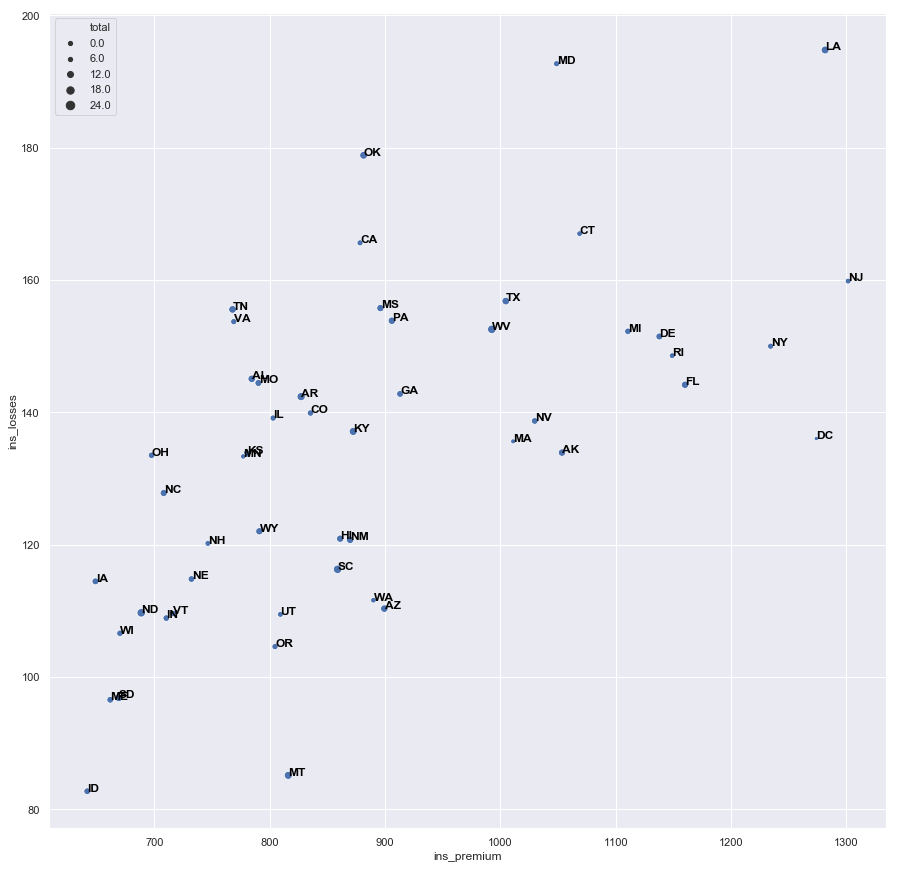

In [28]:
#Refer to https://python-graph-gallery.com/46-add-text-annotation-on-scatterplot/
sns.set()
plt.figure(figsize=(15,15))
p = sns.scatterplot(x='ins_premium', y='ins_losses', data=df_car_crashes, size=df_car_crashes['total'])
for line in range(0, df_car_crashes.shape[0]):
    p.text(df_car_crashes.ins_premium[line]+0.2, df_car_crashes.ins_losses[line], pd.Series(df_car_crashes.index)[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.show()

**20) [P] Generate two interesting scatterplots that show some relationships between variables in the data. Try to
use as many variables as you can without creating chaos! Your aim is to derive meaning from your data. Good
visualizations tell a story. Strive to use at least one additional variable as size, color, or shape in your data, so
you can show more than just 2 variables on a single plot. Remember, sometimes this can just confuse, so do
not go overboard unless it really adds something. Be sure to add legends and colorbors and axis labels and
titles, and etc!
Then, write a single sentence in markdown that draws a conclusion from your plot.**

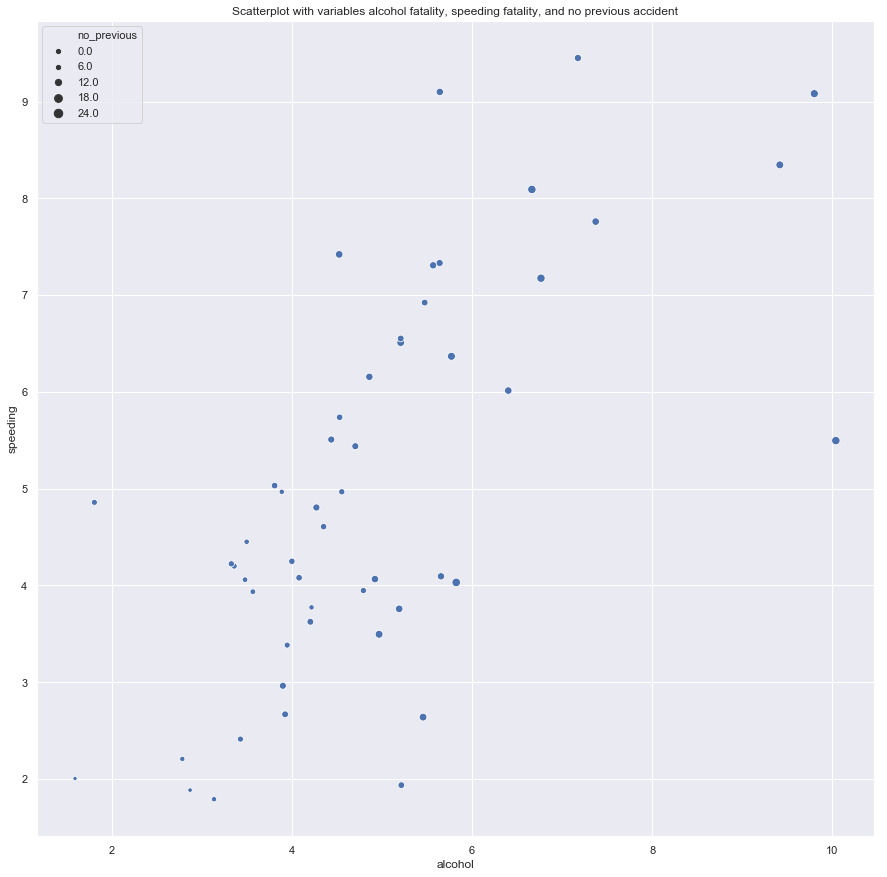

In [29]:
sns.set()
plt.figure(figsize=(15,15))
p = sns.scatterplot(x='alcohol', y='speeding', data=df_car_crashes, size='no_previous')
plt.title("Scatterplot with variables alcohol fatality, speeding fatality, and no previous accident")
plt.show()

From the above scatterplot, it can be seen that there is a positive correlation between alcohol-caused accidents and speeding-caused accidents as well as a correlation between alcohol-caused accidents and accidents by drivers with no previous accident record. This may imply drivers are more likely to speed when drunk and are also more prone to drunk driving when they don't have a previous accident, exposing them to the risk of a fatal crash.

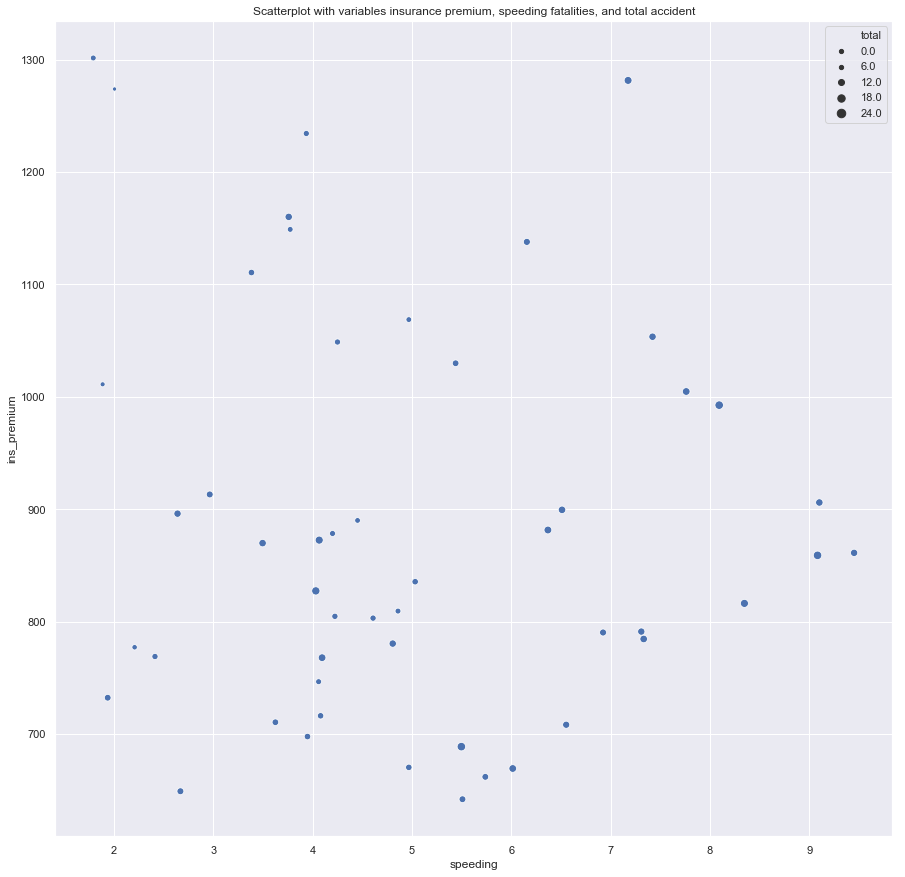

In [30]:
sns.set()
plt.figure(figsize=(15,15))
p = sns.scatterplot(x='speeding', y='ins_premium', data=df_car_crashes, size='total')
plt.title("Scatterplot with variables insurance premium, speeding fatalities, and total accident")
plt.show()

It appears that higher speeding deaths do not influence insurance premiums while insurance premiums are also not influenced by total deaths per 100,000 people.

**21) [P] Since all of the data are numeric, create a zscore transformation, storing the new dataframe as
df_car_crashes_zscore. Report summary statistics on the transformed data.**

In [31]:
scaler = preprocessing.MinMaxScaler()
df_car_crashes_zscore = pd.DataFrame(scaler.fit_transform(df_car_crashes), columns=df_car_crashes.columns, index=df_car_crashes.index)

In [32]:
df_car_crashes_zscore.describe()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,0.549455,0.418673,0.390028,0.539390,0.526975,0.371456,0.461869
std,0.229000,0.263482,0.204752,0.205880,0.244777,0.270326,0.221690
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.380556,0.257835,0.272469,0.398064,0.354226,0.191749,0.284701
50%,0.538889,0.367720,0.350622,0.552349,0.512029,0.329022,0.475765
75%,0.700000,0.606816,0.474956,0.656591,0.705787,0.554893,0.616978
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**22) [P] Now, run a full PCA on the transformed data. Set n_components to be the same number of components
as the original data. Be sure to fit the data to your PCA model, and then output the components, explained
variance, and the explained variance ratio.**

In [33]:
# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
pca = PCA(n_components=df_car_crashes_zscore.columns.size)
principalComponents = pca.fit_transform(df_car_crashes_zscore)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component ' + str(i) for i in range(df_car_crashes_zscore.columns.size)])
principalDf

,principal component 0,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6
0,-0.380783,0.005632,-0.105949,-0.191037,-0.113908,-0.010183,0.047723
1,-0.284123,0.267690,-0.175898,0.089806,0.005480,-0.210705,0.004034
2,-0.347683,-0.044016,-0.072925,0.157797,0.072404,-0.156635,-0.015532
3,-0.533247,0.054999,0.456336,0.035452,-0.063826,-0.121222,-0.032556
4,0.388934,0.088464,0.004570,-0.252006,-0.059443,0.017055,-0.016307
5,0.181025,-0.060870,-0.056531,-0.127671,0.047665,-0.050141,-0.021773
6,0.485560,0.316069,-0.189092,-0.131875,-0.033112,0.098210,0.003183
7,-0.073314,0.422841,-0.084938,0.076550,0.043490,-0.090582,-0.042428
8,1.081565,0.286801,-0.154768,0.270312,-0.036324,-0.016163,-0.029303
9,-0.060456,0.391886,0.211241,0.256112,-0.028035,-0.052342,-0.019560


In [34]:
pca.explained_variance_ratio_

array([ 0.5458744 ,  0.24902541,  0.09189022,  0.05314714,  0.03233483,
        0.02391145,  0.00381655])

**23) [M] Use your intuition – what do the weights of the first couple of components suggest explains most of the
variance in the data?**

The first couple of components have the largest explained variance ratios and so they are two components that are most common along all dimensions.

**24) [P] Create a plot of the cumulative sum of the explained variance. How many components will get you to 90%
of the explained variance?**

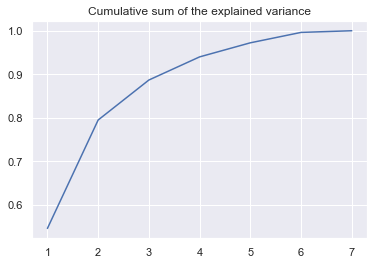

In [35]:
cum_sum = np.cumsum(pca.explained_variance_ratio_)
sns.set()
plt.plot(range(1, len(cum_sum)+1), cum_sum)
plt.title('Cumulative sum of the explained variance')
plt.show()

We need 4 components to capture 90 % of explained variance.

**25) [P] Transform the original data using your PCA model (i.e. using the transform function of the pca object.)**

In [36]:
principalComponents = pca.fit_transform(df_car_crashes)
principalDf = pd.DataFrame(data=principalComponents, columns=['component ' + str(i) for i in range(df_car_crashes.columns.size)])

**26) [P] Generate a 2D plot using the first two principal components as your x and y coordinates. Be sure to label
each point, and label your axes as component 1 and component 2, respectively.**

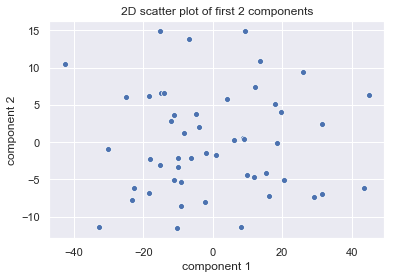

In [37]:
sns.set()
sns.scatterplot(x='component 1', y='component 2', data=principalDf)
plt.title("2D scatter plot of first 2 components")
plt.show()

**27) [M] Observe your plot, and report three "interesting" states from your data that represent some extreme
values or outliers from the trends.**

Three outliers consist of one point lower than -40 on the component 1 axis and the two points greater than 40 on component 1 axis as well.

**28) [P] Read how to generate a 3D scatterplot, and use it to generate a scatterplot of the first 3 components.**

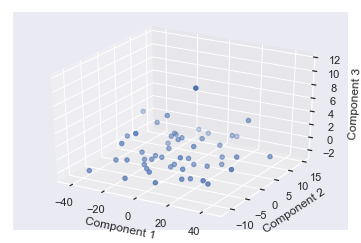

In [38]:
sns.set()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(principalDf['component 1'], principalDf['component 2'], principalDf['component 3'])
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.show()

**29) [M] Do the same outliers still stand out?**

Only one of the original outliers still stands out, since more extreme outliers have appeared along component 3